In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

In [14]:
train = pd.read_csv("C:\\Users\\abuba\\OneDrive\\Documents\\train.csv")
test  = pd.read_csv("C:\\Users\\abuba\\OneDrive\\Documents\\test.csv")

print(train.shape, test.shape)
train.head()

(891, 12) (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


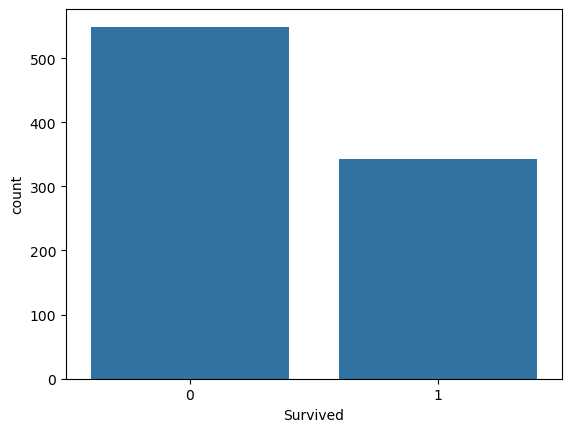

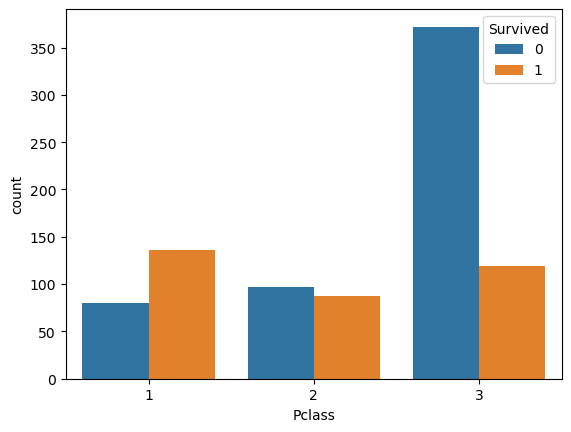

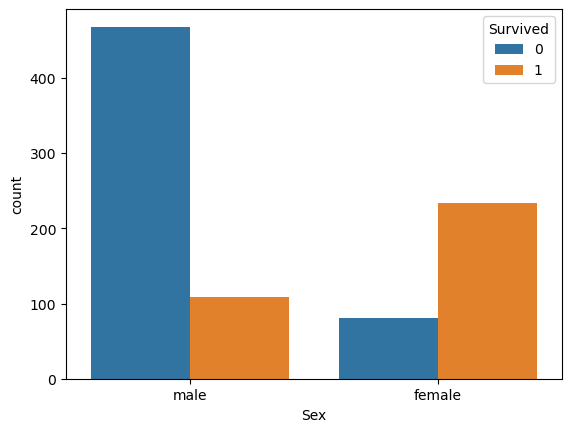

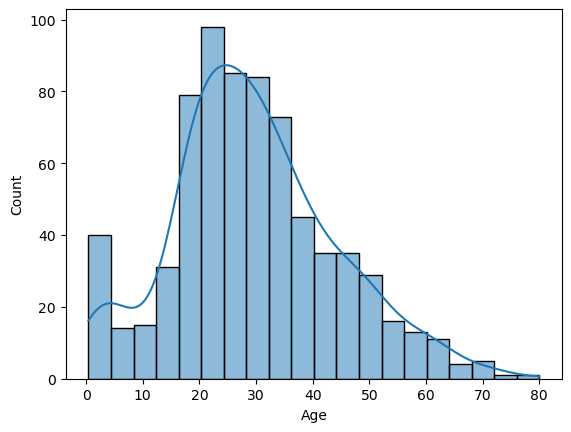

In [16]:
train.info()
train.isna().sum().sort_values(ascending=False)

sns.countplot(x="Survived", data=train); plt.show()
sns.countplot(x="Pclass", hue="Survived", data=train); plt.show()
sns.countplot(x="Sex", hue="Survived", data=train); plt.show()
sns.histplot(train["Age"].dropna(), kde=True); plt.show()

In [18]:
import re

def extract_title(name):
    m = re.search(r",\s*([^.]*)\.", name)
    return m.group(1).strip() if m else "Unknown"

def add_features(df):
    d = df.copy()
    # Title
    d["Title"] = d["Name"].apply(extract_title).replace({
        "Mlle":"Miss","Ms":"Miss","Mme":"Mrs",
        "Lady":"Royalty","Countess":"Royalty","Dona":"Royalty","Sir":"Royalty","Jonkheer":"Royalty","Don":"Royalty",
        "Dr":"Officer","Col":"Officer","Major":"Officer","Capt":"Officer","Rev":"Officer"
    })
    # Family features
    d["FamilySize"] = d["SibSp"] + d["Parch"] + 1
    d["IsAlone"]   = (d["FamilySize"] == 1).astype(int)
    return d

train_fe = add_features(train)
test_fe  = add_features(test)

In [20]:
features = ["Pclass","Sex","Age","SibSp","Parch","Fare","Embarked","Title","FamilySize","IsAlone"]
target   = "Survived"

X = train_fe[features]
y = train_fe[target]
X_test_infer = test_fe[features]

In [22]:
num_cols = ["Age","SibSp","Parch","Fare","FamilySize","IsAlone"]
cat_cols = ["Pclass","Sex","Embarked","Title"]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False))
])
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols)
])

LogReg CV: 0.8204255853367648 ± 0.023838445337074667
Val acc: 0.8491620111731844


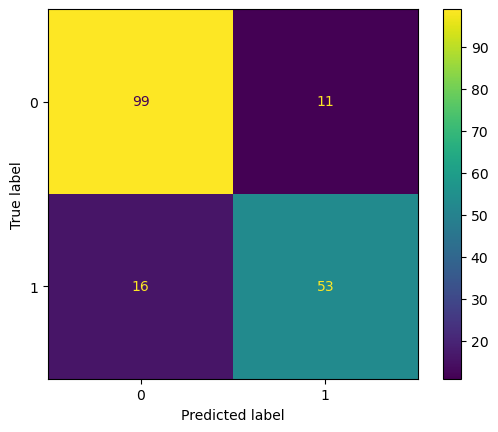

In [24]:
log_reg = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=1000))
])

scores = cross_val_score(log_reg, X, y, cv=5, scoring="accuracy")
print("LogReg CV:", scores.mean(), "±", scores.std())

X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
log_reg.fit(X_tr, y_tr)
pred = log_reg.predict(X_val)
print("Val acc:", accuracy_score(y_val, pred))
ConfusionMatrixDisplay.from_predictions(y_val, pred); plt.show()

RF CV: 0.8024857196660597 ± 0.03233605839978576
Val acc: 0.7988826815642458
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       110
           1       0.75      0.72      0.74        69

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



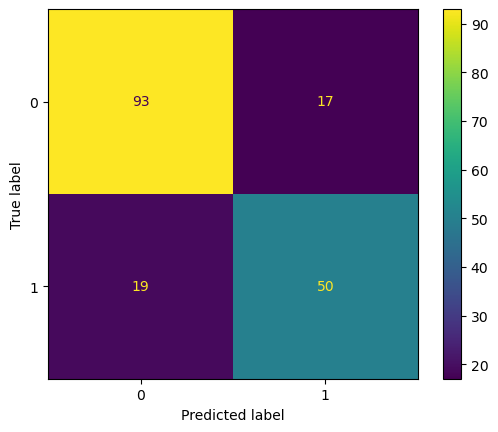

In [26]:
rf = Pipeline([
    ("prep", preprocess),
    ("clf", RandomForestClassifier(n_estimators=400, random_state=42))
])

scores = cross_val_score(rf, X, y, cv=5, scoring="accuracy")
print("RF CV:", scores.mean(), "±", scores.std())

rf.fit(X_tr, y_tr)
pred = rf.predict(X_val)
print("Val acc:", accuracy_score(y_val, pred))
print(classification_report(y_val, pred))
ConfusionMatrixDisplay.from_predictions(y_val, pred); plt.show()

In [28]:
best_model = rf  
best_model.fit(X, y)

test_pred = best_model.predict(X_test_infer)
submission = pd.DataFrame({
    "PassengerId": test_fe["PassengerId"],
    "Survived": test_pred.astype(int)
})
submission.to_csv("submission.csv", index=False)
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,0
